In [2]:
#IMPORT all Packages we need for this feature.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy import ndimage
from persim import plot_diagrams 
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [91]:
Catalog_train=pd.read_pickle('Catalog_train.pkl')
Catalog_test=pd.read_pickle('Catalog_test.pkl')

In [4]:
Catalog_train.head()

,AUTHOR,URL,Vangogh,URL_small,Image
0,"GOGH, Vincent van",https://www.wga.hu/art/g/gogh_van/13/copies01.jpg,1,https://www.wga.hu/detail/g/gogh_van/13/copies...,"[[[52, 51, 71], [92, 93, 113], [101, 106, 127]..."
1,"RUBENS, Peter Paul",https://www.wga.hu/art/r/rubens/22mythol/281my...,0,https://www.wga.hu/detail/r/rubens/22mythol/28...,"[[[37, 33, 45], [39, 35, 47], [42, 38, 50], [4..."
2,"GOGH, Vincent van",https://www.wga.hu/art/g/gogh_van/18/2arles10.jpg,1,https://www.wga.hu/detail/g/gogh_van/18/2arles...,"[[[243, 235, 236], [240, 232, 233], [236, 228,..."
3,"GOGH, Vincent van",https://www.wga.hu/art/g/gogh_van/03/nuenen40.jpg,1,https://www.wga.hu/detail/g/gogh_van/03/nuenen...,"[[[31, 38, 31], [31, 38, 31], [30, 34, 29], [2..."
4,"VERMEER, Johannes",https://www.wga.hu/art/v/vermeer/03c/25artpa5.jpg,0,https://www.wga.hu/detail/v/vermeer/03c/25artp...,"[[[57, 55, 61], [49, 47, 53], [44, 42, 48], [4..."


In [5]:
#Functions
def get_image(url):
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_image(image):
    plt.figure(figsize=(15,8))
    b,g,r = cv2.split(image)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb

    plt.imshow(rgb_img)
    plt.xticks([]); plt.yticks([])   # to hide tick values on X and Y axis

def preprocess_image_gray(image):
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = ndimage.uniform_filter(image.astype(np.float64), size=5)
    image += 0.01 * np.random.randn(*image.shape)  
    return image

In [7]:
def gray_histogram(url,plot,plot_original=False):
    #Read Image
    image=get_image(url)
    
    #PreProcess
    image=preprocess_image_gray(image)
    image=MinMaxScaler().fit_transform(StandardScaler().fit_transform(image.reshape(-1, 1)))
    image=np.multiply(image,255)
    
    if plot_original:
        plt.figure(figsize=(15,10))
        plt.title('Original')
        fig,ax0 = plt.subplots(1,figsize=(15,10))
        ax0.imshow(image,cmap='gray')
        ax0.set_title('Gray Smoothed Normalized')

    #Histogram
    hist = cv2.calcHist([np.float32(image)], [0], None, [256], [0, 256])
    hist = np.divide(hist,max(hist))
    if plot:
        plt.figure()
        plt.title("Grayscale Histogram")
        plt.xlabel("Bins")
        plt.ylabel("# of Pixels")
        plt.plot(hist)
        plt.xlim([0, 256])
    return hist

def ordered_histogram(url):
    hist=gray_histogram(url,False,False)
    order_hist=np.sort(hist.reshape(1,-1))
    order_hist=np.divide(order_hist.reshape(-1,1),order_hist[0,255])
    plt.figure()
    plt.title("Ordered Grayscale Histogram")
    plt.xlabel("Reordered Bins")
    plt.ylabel("# of Pixels")
    plt.plot(order_hist)
    plt.xlim([0, 255])
    return order_hist

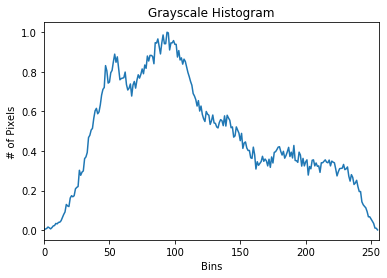

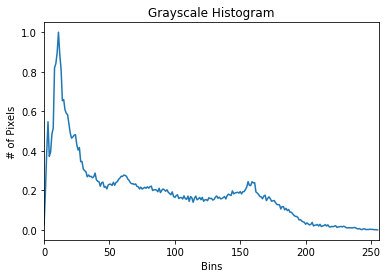

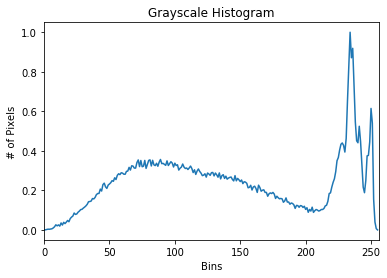

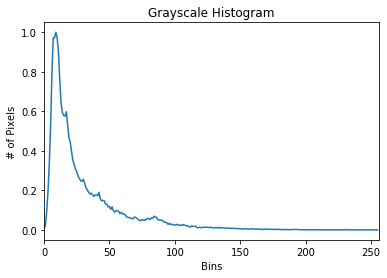

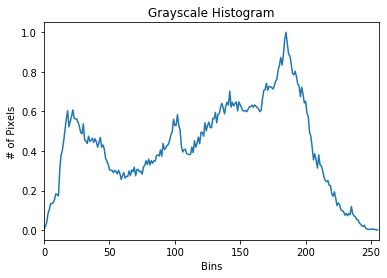

In [8]:
for i in range(5):
    b=gray_histogram(Catalog_train.URL_small[i], plot=True, plot_original=False)

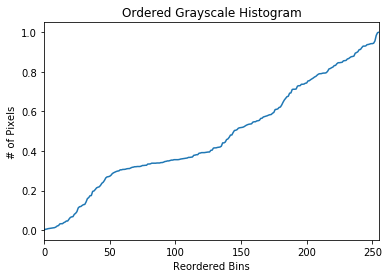

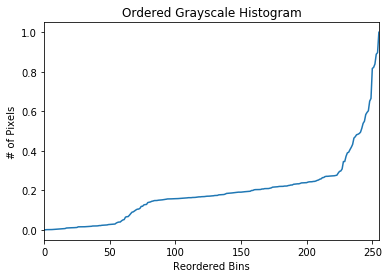

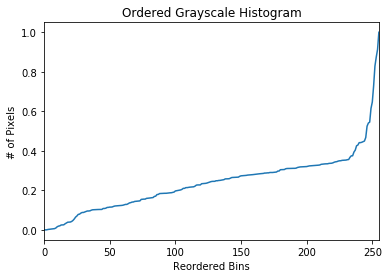

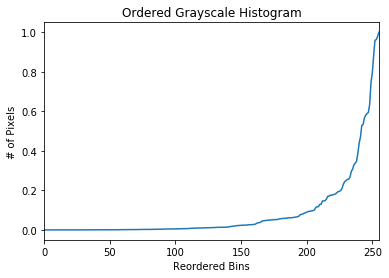

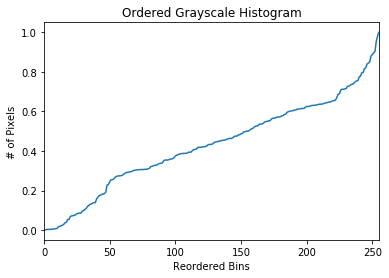

In [9]:
for i in range(5):
    b=ordered_histogram(Catalog_train.URL_small[i])

In [57]:
#Function to append histogram to an imported Catalog
def append_histogram(Catalog0):
    Catalog=Catalog0.copy()
    N=Catalog.shape[0]
    histogram=np.zeros((N,256))
    Catalog['GNHist']=''
    for ind in Catalog.index:
        url=Catalog.URL_small[ind]
        histogram[ind]=gray_histogram(url,False,False).reshape(1,-1)
    Catalog.GNHist=histogram.tolist()
    return Catalog

In [92]:
Catalog_train_hist=append_histogram(Catalog_train)
Catalog_test_hist=append_histogram(Catalog_test)

In [93]:
X_train=Catalog_train_hist.GNHist
y_train=Catalog_train.Vangogh
X_test=Catalog_test_hist.GNHist
y_test=Catalog_test.Vangogh
X_train=np.array(list(X_train))
X_test=np.array(list(X_test))

In [103]:
# Function to calculate Chi-distace 
def chi2_distance(A, B): 
    A=np.array(A)
    B=np.array(B)
    # compute the chi-squared distance
    chi=0
    for (a, b) in zip(A, B):
        if a != b:     
            chi=chi+((a - b) ** 2) / (a + b)
    chi=0.5*chi 
    return chi

In [104]:
# Define the Chi2 distance model and fit
neighChi2 = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric = chi2_distance)
neighChi2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                     metric=<function chi2_distance at 0x000001C90C952DC8>,
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [105]:
neighChi2.score(X_test,y_test)

0.769811320754717

In [98]:
#Function to append ordered histogram to an imported Catalog
def append_ohistogram(Catalog0):
    Catalog=Catalog0.copy()
    N=Catalog.shape[0]
    histogram=np.zeros((N,256))
    Catalog['GNHist']=''
    for ind in Catalog.index:
        url=Catalog.URL_small[ind]
        histogram[ind]=ordered_histogram(url).reshape(1,-1)
    Catalog.GNHist=histogram.tolist()
    return Catalog

In [99]:
Catalog_train_ohist=append_histogram(Catalog_train)
Catalog_test_ohist=append_histogram(Catalog_test)

In [100]:
oX_train=Catalog_train_ohist.GNHist
oX_test=Catalog_test_ohist.GNHist
oX_train=np.array(list(X_train))
oX_test=np.array(list(oX_test))

In [106]:
# Define the Chi2 distance model and fit
oneighChi2 = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric = chi2_distance)
oneighChi2.fit(oX_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                     metric=<function chi2_distance at 0x000001C90C952DC8>,
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [107]:
neighChi2.score(oX_test,y_test)

0.7735849056603774